### Udacity Self Driving Car Nanodegree: Term1: Project  4: Advanced Lane Lines Detection
March 2018
David Escolme

In [1]:
# imports
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import random
import collections
%matplotlib inline

In [2]:
# globals for calibration inside corners
NX = 9
NY = 6

# calibration images
IMG_DIR = 'camera_cal/'
calibration_files = glob.glob(IMG_DIR+"*.jpg")

# test images
TST_DIR = 'test_images/'
test_files = glob.glob(TST_DIR+"*.jpg")

#### Calibration Section
This is where the camera will be calibrated using test chessboard images. The inside corners of the chessboard images are found (these images have 9x and 6y axis inside corners) using opencv functions. Once found, the object and image points are saved to lists and returned to the calling code for use in image undistortion and the lane finding pipeline

In [3]:
def calibrate_camera(calibration_files, nx, ny):
    """ 
        function to calibrate a camera given a list of images 
        
        Args: 
            calibration_files: a list of locations of images
            nx, ny: the number of inside corners on the images
            
        Returns: img and obj points for use in undistortion
    """
    # create the empty return lists
    objpoints = []
    imgpoints = []
    
    # setup the object point array
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    
    # now iterate the file list, open each image, convert to gray and find the corners
    for img in calibration_files:
        img = cv2.imread(img)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # if corners found, then add them to output 
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            
    return (objpoints, imgpoints)

#### Undistortion
When the camera is calibrated, the calibration points can be fed into the opencv undistort function to return an undistorted image

In [4]:
def img_undistort(img, objpoints, imgpoints):
    """ 
        function to undistort an image
        Args:
            img: the image to process
            objpoints, imgpoints: the calibration coeffs
        Returns:
            undistort: the undistorted image
    """
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

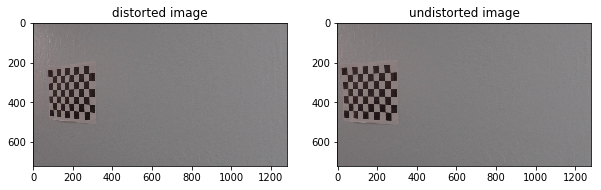

In [5]:
# let's test the calibration and undistortion functions
# calibrate the camera using the calbration files folder
def test_calibration():
    testobj, testimg = calibrate_camera(calibration_files, NX, NY)
    # read a random calibration file
    img = cv2.imread(calibration_files[random.randrange(len(calibration_files))])
    img_undistorted = img_undistort(img, testobj, testimg)
    # show the results
    plt.figure(figsize=(10,5))
    ax = plt.subplot(121)
    ax.imshow(img)
    ax.set_title('distorted image')
    ax = plt.subplot(122)
    ax.imshow(img_undistorted)
    ax.set_title('undistorted image')
    plt.show()
    
test_calibration()

#### Thresholding
Having obtained an undistorted image, various threshold techniques can be applied, some in combination, to identify lane lines. This using gradient threshold or color space threshold.

In [6]:
def sobel_thresh_abs(img, orient='x', thresh=(20,100)):
    """
        function to return a sobel absolute threshold
        fixed kernel size of 9 used in this function
        Args: 
            img: the undistorted image to threshold
            orient: whether to apply x or y axis
            thresh: the min and max threshold values
        Returns:
            sbinary: a thresholded binary image
        
    """
    # get grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # do sobel
    if orient == 'x':
        sobelv = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=9)
    else:
        sobelv = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=9)
    # abssolute value
    abs_sobelv = np.absolute(sobelv)
    scaled_sobelv = np.uint8(255*abs_sobelv/np.max(abs_sobelv))
    # now threshold
    sbinary = np.zeros_like(scaled_sobelv)
    sbinary[(scaled_sobelv >= thresh[0]) & (scaled_sobelv <= thresh[1])] = 1
    return sbinary

In [7]:
def sobel_thresh_mag(img, sobel_kernel=3, thresh=(0, 255)):
    """
        function to return a sobel magnitude threshold
        Args: 
            img: the undistorted image to threshold
            sobel_kernel: the kernel value (odd number)
            thresh: the min and max threshold values
        Returns:
            sxybinary: a thresholded binary image
        
    """
    # convert to gray
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # calculate the magnitude 
    abs_sobelxy = np.sqrt(np.square(sobelx)+np.square(sobely))
    # scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # create a binary mask where mag thresholds are met
    sxybinary = np.zeros_like(scaled_sobel)
    sxybinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # return this mask as your binary_output image
    return sxybinary

In [8]:
def sobel_thresh_dir(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    """
        function to return a sobel direction threshold
        Args: 
            img: the undistorted image to threshold
            sobel_kernel: the kernel value (odd number)
            thresh: the min and max threshold values
        Returns:
            sbinary: a thresholded binary image
        
    """
    # convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    # create a binary mask where direction thresholds are met
    sbinary = np.zeros_like(grad_dir)
    sbinary[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    # return this mask as your binary_output image
    return sbinary

In [9]:
def hls_select(img, thresh=(0, 255)):
    """
        function to return a hls color threshold
        Args: 
            img: the undistorted image to threshold
            thresh: the min and max threshold values
        Returns:
            sbinary: a thresholded binary image
        
    """
    # convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    # apply a threshold to the S channel
    sbinary = np.zeros_like(s_channel)
    sbinary[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    # return a binary image of threshold result
    return sbinary

In [10]:
def hsv_select(img, thresh=(0, 255)):
    """
        function to return a hsv color threshold
        Args: 
            img: the undistorted image to threshold
            thresh: the min and max threshold values
        Returns:
            sbinary: a thresholded binary image
        
    """
    # convert to HLS color space
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    s_channel = hsv[:,:,1]
    # apply a threshold to the S channel
    sbinary = np.zeros_like(s_channel)
    sbinary[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    # return a binary image of threshold result
    return sbinary

#### Perspective Transform
After applying a threshold, the next step of the pipeline involves creating a bird's eye view of the road surface using a perspective transform (in this case a trapezoid to rectangle transformation) and allowing for the inverse to be done when lines are detected so they can be applied to the road surface.

In [11]:
def apply_perspective_transform(img, reverse=False, src=None, dst=None):
    """
        function to apply a perspective transform or invert it
        default source and destination shapes are provided in case none are passed in
        Args: 
            img: the undistorted image to threshold
            reverse: whether to invert or not
            src, dst: corners to transform from / to tr,br,bl,tl
        Returns:
            an image transformed to new coordinates
    """
    # get image size
    img_size = (img.shape[1], img.shape[0])
    mid_x = img_size[0]//2
    top_width = 95
    bottom_width = 450
    top_start = 2*img_size[1]//3
    
    src_points = [
        (mid_x+top_width, top_start),
        (mid_x+bottom_width, img_size[1]),
        (mid_x-bottom_width, img_size[1]),
        (mid_x-top_width, top_start)
    ]
    
    dst_points = [
        (mid_x+bottom_width, 0),
        (mid_x+bottom_width, img_size[1]),
        (mid_x-bottom_width, img_size[1]),
        (mid_x-bottom_width, 0)
    ]
    
    # coordinates
    if not src: src = np.float32(src_points)
    if not dst: dst = np.float32(dst_points)

    # get transform
    if not reverse:
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        M = cv2.getPerspectiveTransform(dst, src)
    
    return cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

In [12]:
def apply_region_of_interest(img, vertices=None, output_type=None):
    """
        Applies an image mask.
        Only keeps the region of the image defined by the polygon
        formed from `vertices`. 
        Args:
            img: the image to mask can be binary or color
            vertices: the area to apply the mask to
        Returns:
            a masked image
    """
    # setup default vertices if none passed
    if not vertices:
        vertices = np.array([[(800,400),(1200, 700), (200, 700), (500, 400)]], dtype=np.int32)
    
    #defining a blank mask to start with
    mask = np.zeros_like(img)   

    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    
    # now scale to 0,1
    masked_binary = np.zeros_like(masked_image)
    masked_binary[(masked_image > 0)] = 1
    
    return masked_binary

In [13]:
def return_histogram(img):
    """
        function to take a binary image and return a histogram for the bottom half
        Args:
            img: binary image
        Returns:
            histogram: the histogram
    """
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    return histogram

### Showing the results of image transformation for the test set
this section trials various combinations of the pipeline functions to establish a good fit for threshold and perspective transformation

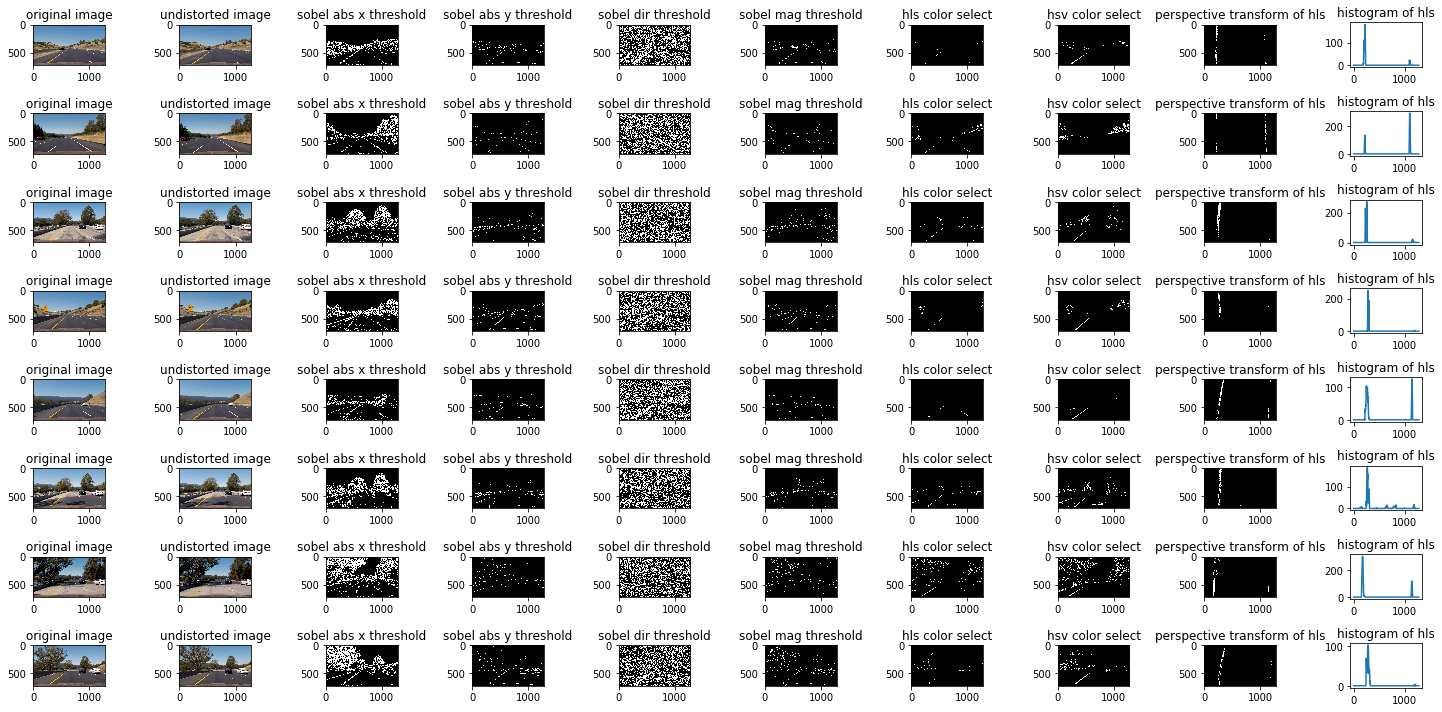

In [14]:
def print_image(img, fig, r, c, i, cmap=None, isimg=True, title=None):
    """
        not sure this is useful but function to print out images in grid
        Args:
            img: the image/plt to show
            fig, r, c, i: the figure and its subplot coordinates for the image to show
            cmap: color map for an image
            isimg: if not an image just plot
        Returns:
            next subplot number
    """
    ax = fig.add_subplot(r, c, i)
    if isimg:
        plt.imshow(img, cmap)
    else:
        plt.plot(img)
    if title: ax.set_title(title)
    i += 1
    return i

def process_images(test_files):
    """
        function to process the test image set
        prints the results
        Args:
            test_files: the list of files to process
    """
    # calibrate the camera
    testobj, testimg = calibrate_camera(calibration_files, NX, NY)
    fig=plt.figure(figsize=(20, 10))
    # iterate test_files and create a list of images
    i = 1
    r = len(test_files)
    c = 10
    for file in test_files:
        img = cv2.imread(file)
        undistort = img_undistort(img, testobj, testimg)
        sobel_x = sobel_thresh_abs(undistort, 'x', (10, 100))
        sobel_y = sobel_thresh_abs(undistort, 'y', (60, 120))
        sobel_dir = sobel_thresh_dir(undistort, 15, (0.7,1.3))
        sobel_mag = sobel_thresh_mag(undistort, 15, (60,120))
        color_select = hls_select(undistort, (155,240))
        color_select2 = hsv_select(undistort, (155,240))
        transformed = apply_perspective_transform(color_select)
        transformed2 = apply_perspective_transform(color_select2)
        histogram = return_histogram(transformed)
        i = print_image(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), fig, r, c, i, title='original image')
        i = print_image(cv2.cvtColor(undistort, cv2.COLOR_BGR2RGB), fig, r, c, i, title='undistorted image')
        i = print_image(sobel_x, fig, r, c, i, 'gray', title='sobel abs x threshold')
        i = print_image(sobel_y, fig, r, c, i, 'gray', title='sobel abs y threshold')
        i = print_image(sobel_dir, fig, r, c, i, 'gray', title='sobel dir threshold')
        i = print_image(sobel_mag, fig, r, c, i, 'gray', title='sobel mag threshold')
        i = print_image(color_select, fig, r, c, i, 'gray', title='hls color select')
        i = print_image(color_select2, fig, r, c, i, 'gray', title='hsv color select')
        i = print_image(transformed, fig, r, c, i, 'gray', title='perspective transform of hls')
        i = print_image(histogram, fig, r, c, i, isimg=False, title='histogram of hls')
    plt.tight_layout()
    plt.show()
    
# let's run through each image after calibrating the camera

process_images(test_files)

In [15]:
def get_combined(img, testobj, testimg, 
                 ksize=7, sobel_thresh=(50, 100), direction_thresh=(0.7, 1.3), color_thresh=(40, 190)):
    """
        function to combined binary thresholds
        Args:
            img: the image to threshold
            testobj, testimg: camera calibration coeffs
            ksize, sobel_thresh, direction_thresh, color_thresh: parameters for the threshold functions
        Returns:
            a combined threshold across all the thresholds
    """
    # undistort the image
    undistorted = img_undistort(img, testobj, testimg)
    # apply all the thresholds 
    gradx = sobel_thresh_abs(undistorted, 'x', thresh=(sobel_thresh[0], sobel_thresh[1]))
    grady = sobel_thresh_abs(undistorted, 'y', thresh=(sobel_thresh[0], sobel_thresh[1]))
    mag_binary = sobel_thresh_mag(undistorted, ksize, thresh=(sobel_thresh[0], sobel_thresh[1]))
    dir_binary = sobel_thresh_dir(undistorted, ksize, thresh=(direction_thresh[0], direction_thresh[1]))
    color_select = hls_select(undistorted, (color_thresh[0], color_thresh[1]))

    # combine the gradient thresholds
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    # combine with color threshold
    combined_binary = np.zeros_like(combined)
    combined_binary[(combined == 1) | (color_select == 1)] = 1

    return combined_binary

def get_gradhls_combined(img, sobel_thresh=(20, 100), color_thresh=(150, 255)):
    """
        function to combined binary thresholds over sobel_abs_x and hls
        Args:
            img: the undistorted image
            sobel_thresh, color_thresh: parameters for the threshold functions
        Returns:
            a combined threshold across all the thresholds
    """
    # get the thresholds
    gradx = sobel_thresh_abs(img, 'x', thresh=(sobel_thresh[0], sobel_thresh[1]))
    color_select = hls_select(img, (color_thresh[0], color_thresh[1]))

    # combine them
    combined_binary = np.zeros_like(gradx)
    combined_binary[(gradx == 1) | (color_select == 1)] = 1

    return combined_binary

def get_color_combined(img, testobj, testimg,
                       ksize=7, sobel_thresh=(50, 100), direction_thresh=(0.7, 1.3), color_thresh=(40, 190)):
    """
        function to combined binary thresholds
        Args:
            img: the image to threshold
            testobj, testimg: camera calibration coeffs
            ksize, sobel_thresh, direction_thresh, colo_thresh: parameters for the threshold functions
        Returns:
            a combined image
    """
    # undistort image
    undistorted = img_undistort(img, testobj, testimg)
    
    # get thresholds
    gradx = sobel_thresh_abs(undistorted, 'x', thresh=(sobel_thresh[0], sobel_thresh[1]))
    color_select = hls_select(undistorted, (color_thresh[0], color_thresh[1]))

    # combine the images
    color_binary = np.dstack(( np.zeros_like(gradx), gradx, color_select)) * 255
    
    return color_binary

### Experimentation with thresholds and regions of interest

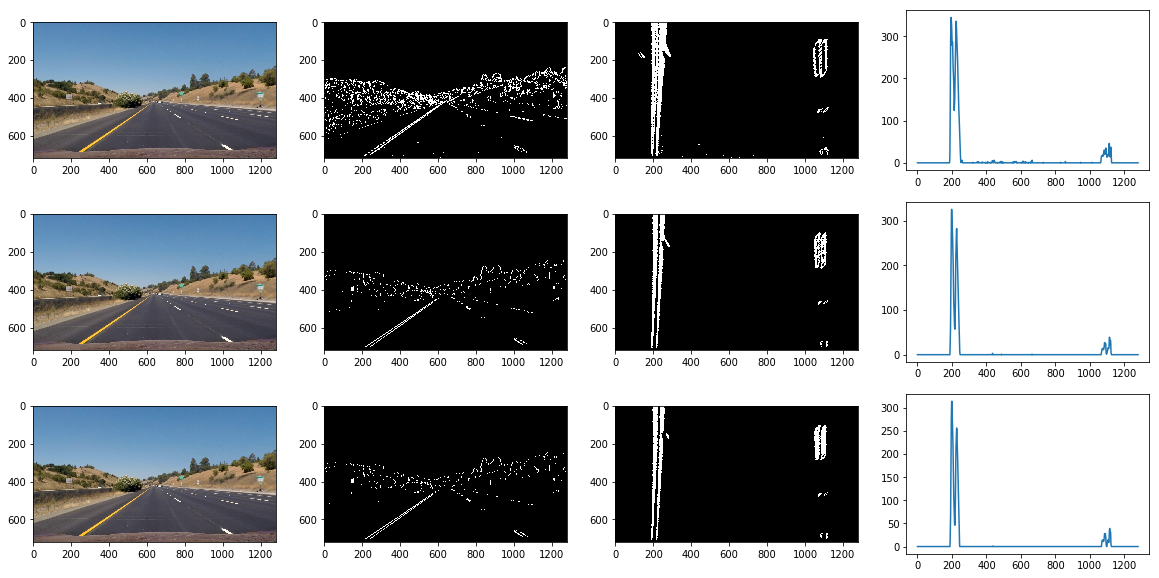

In [16]:
# individual selections - with histograms
def sobel_abs_tune():
    """
        function to tune sobel_abs_x
    """
    # calibrate the camera
    testobj, testimg = calibrate_camera(calibration_files, NX, NY)
    
    # open a random test image
    img = cv2.imread(test_files[random.randrange(len(test_files))])
    
    # undistort the image
    undistorted = img_undistort(img, testobj, testimg)
    
    # prepare paramters
    sobel_thresh = [
        [20,100],
        [45,135],
        [50,150]
    ]
    # gradx
    fig=plt.figure(figsize=(20, 10))
    i = 1
    r = 3
    c = 4
    for x in range(3):
        gradx = sobel_thresh_abs(undistorted, 'x', thresh=(sobel_thresh[x][0], sobel_thresh[x][1]))
        transformed = apply_perspective_transform(gradx)
        histogram = return_histogram(transformed)
        i = print_image(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), fig, r, c, i)
        i = print_image(gradx, fig, r, c, i, cmap='gray')
        i = print_image(transformed, fig, r, c, i, cmap='gray')
        i = print_image(histogram, fig, r, c, i, isimg=False)

sobel_abs_tune()

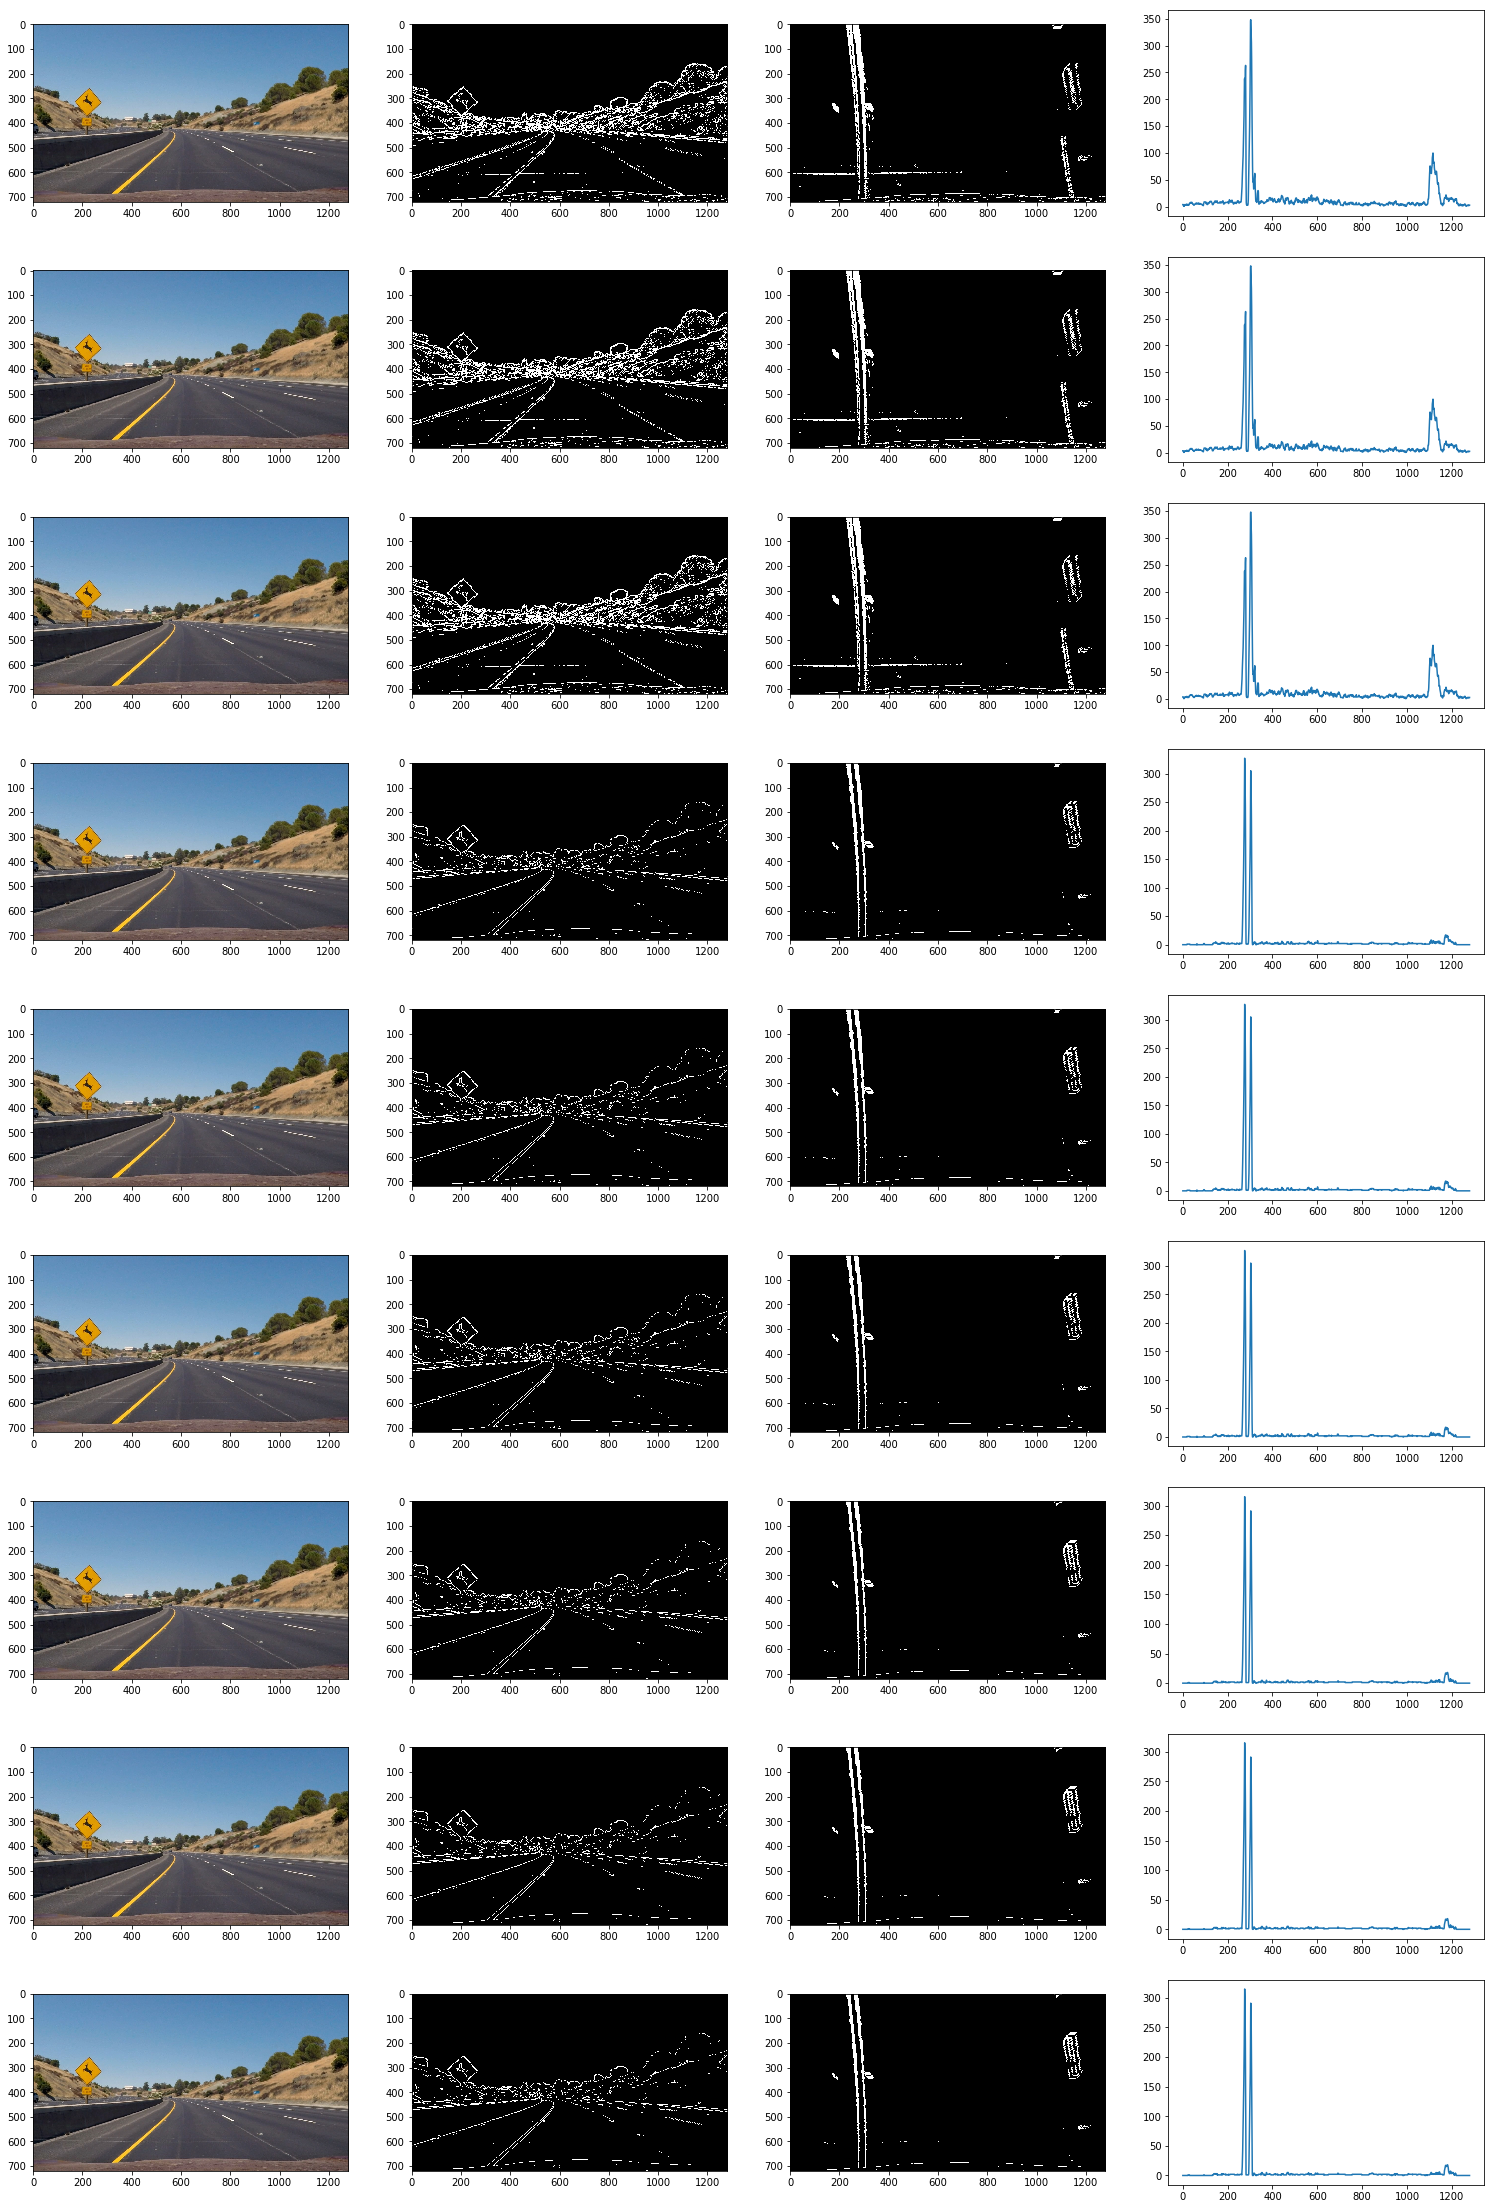

In [17]:
def sobel_mag_tune():
    """
        function to tune sobel_mag
    """
    testobj, testimg = calibrate_camera(calibration_files, NX, NY)
    img = cv2.imread(test_files[random.randrange(len(test_files))])
    undistorted = img_undistort(img, testobj, testimg)
    ksize = [7,11,15]
    sobel_thresh = [
        [20,100],
        [45,135],
        [50,150]
    ]
    # gradx
    fig=plt.figure(figsize=(26, 40))
    i = 1
    r = 9
    c = 4
    for x in range(3):
        for y in range(3):
            gradx = sobel_thresh_mag(undistorted, ksize[y], thresh=(sobel_thresh[x][0], sobel_thresh[x][1]))
            transformed = apply_perspective_transform(gradx)
            histogram = return_histogram(transformed)
            i = print_image(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), fig, r, c, i)
            i = print_image(gradx, fig, r, c, i, cmap='gray')
            i = print_image(transformed, fig, r, c, i, cmap='gray')
            i = print_image(histogram, fig, r, c, i, isimg=False)
    plt.show()
    
sobel_mag_tune()

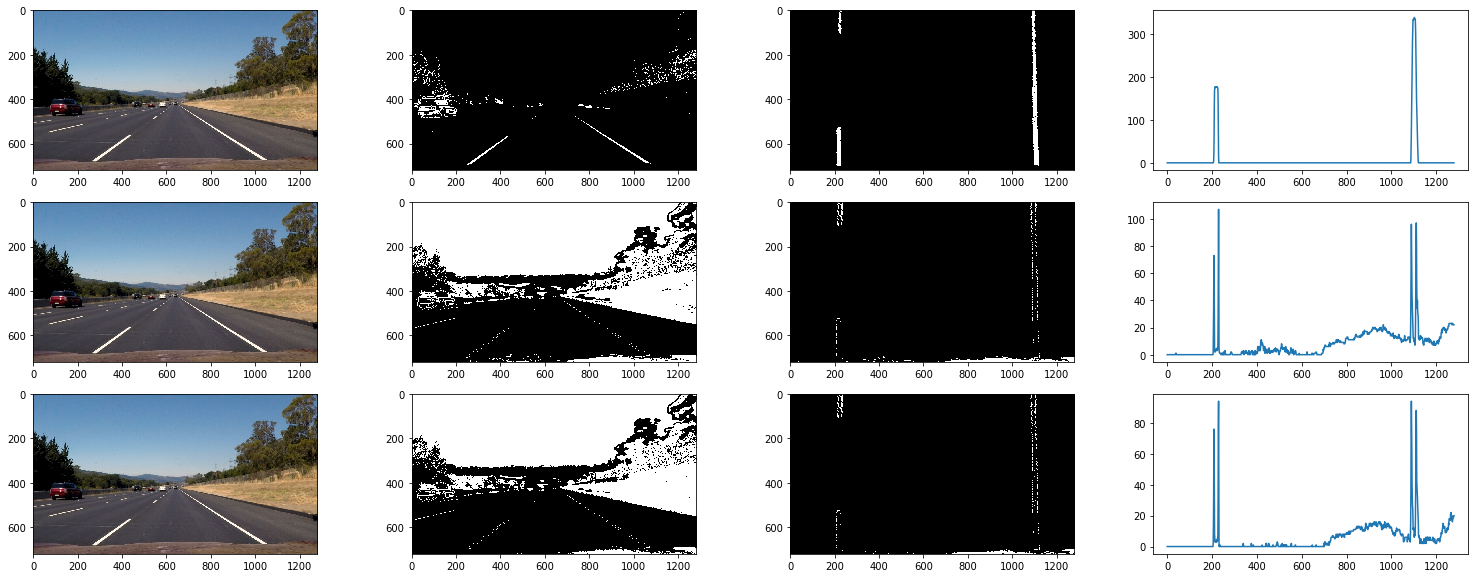

In [18]:
def hls_tune():
    """
        function to tune hls
    """
    testobj, testimg = calibrate_camera(calibration_files, NX, NY)
    img = cv2.imread(test_files[random.randrange(len(test_files))])
    undistorted = img_undistort(img, testobj, testimg)
    sobel_thresh = [
        [150,255],
        [45,135],
        [50,150]
    ]
    # gradx
    fig=plt.figure(figsize=(26, 10))
    i = 1
    r = 3
    c = 4
    for x in range(3):
        gradx = hls_select(undistorted, thresh=(sobel_thresh[x][0], sobel_thresh[x][1]))
        transformed = apply_perspective_transform(gradx)
        histogram = return_histogram(transformed)
        i = print_image(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), fig, r, c, i)
        i = print_image(gradx, fig, r, c, i, cmap='gray')
        i = print_image(transformed, fig, r, c, i, cmap='gray')
        i = print_image(histogram, fig, r, c, i, isimg=False)

hls_tune()

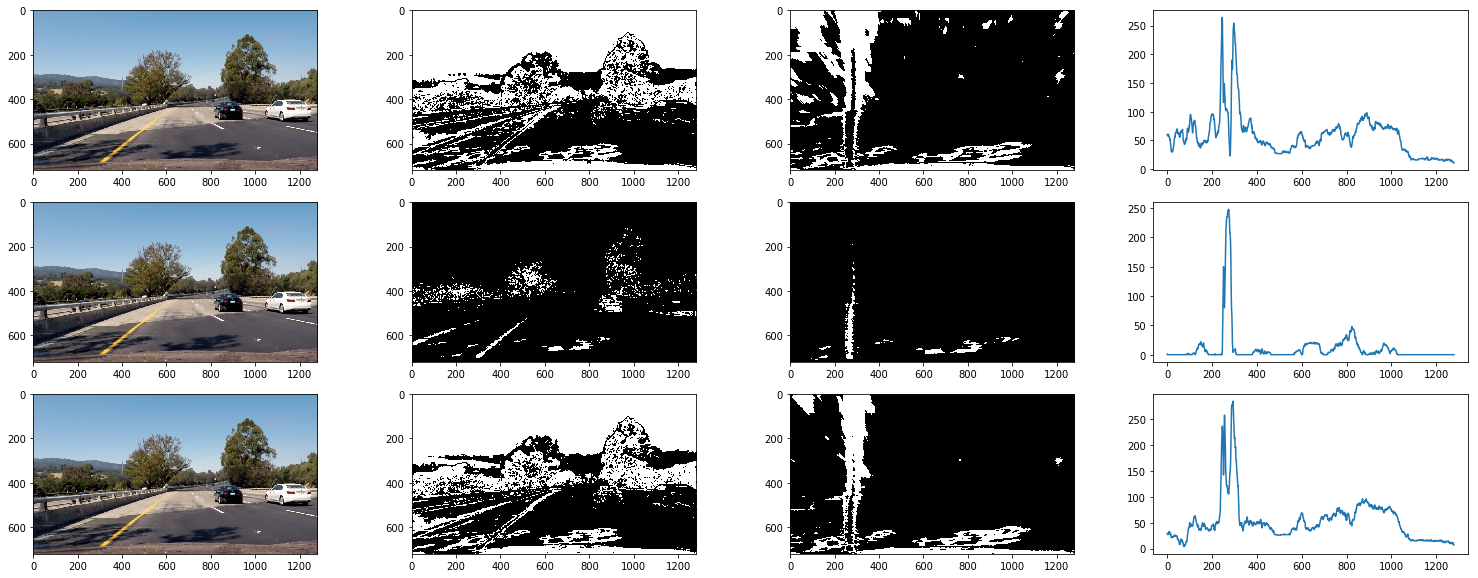

In [19]:
def hsv_tune():
    """
        function to tune hsv
    """
    testobj, testimg = calibrate_camera(calibration_files, NX, NY)
    img = cv2.imread(test_files[random.randrange(len(test_files))])
    undistorted = img_undistort(img, testobj, testimg)
    sobel_thresh = [
        [45,135],
        [150,255],
        [50,150]
    ]
    # gradx
    fig=plt.figure(figsize=(26, 10))
    i = 1
    r = 3
    c = 4
    for x in range(3):
        gradx = hsv_select(undistorted, thresh=(sobel_thresh[x][0], sobel_thresh[x][1]))
        transformed = apply_perspective_transform(gradx)
        histogram = return_histogram(transformed)
        i = print_image(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), fig, r, c, i)
        i = print_image(gradx, fig, r, c, i, cmap='gray')
        i = print_image(transformed, fig, r, c, i, cmap='gray')
        i = print_image(histogram, fig, r, c, i, isimg=False)

hsv_tune()

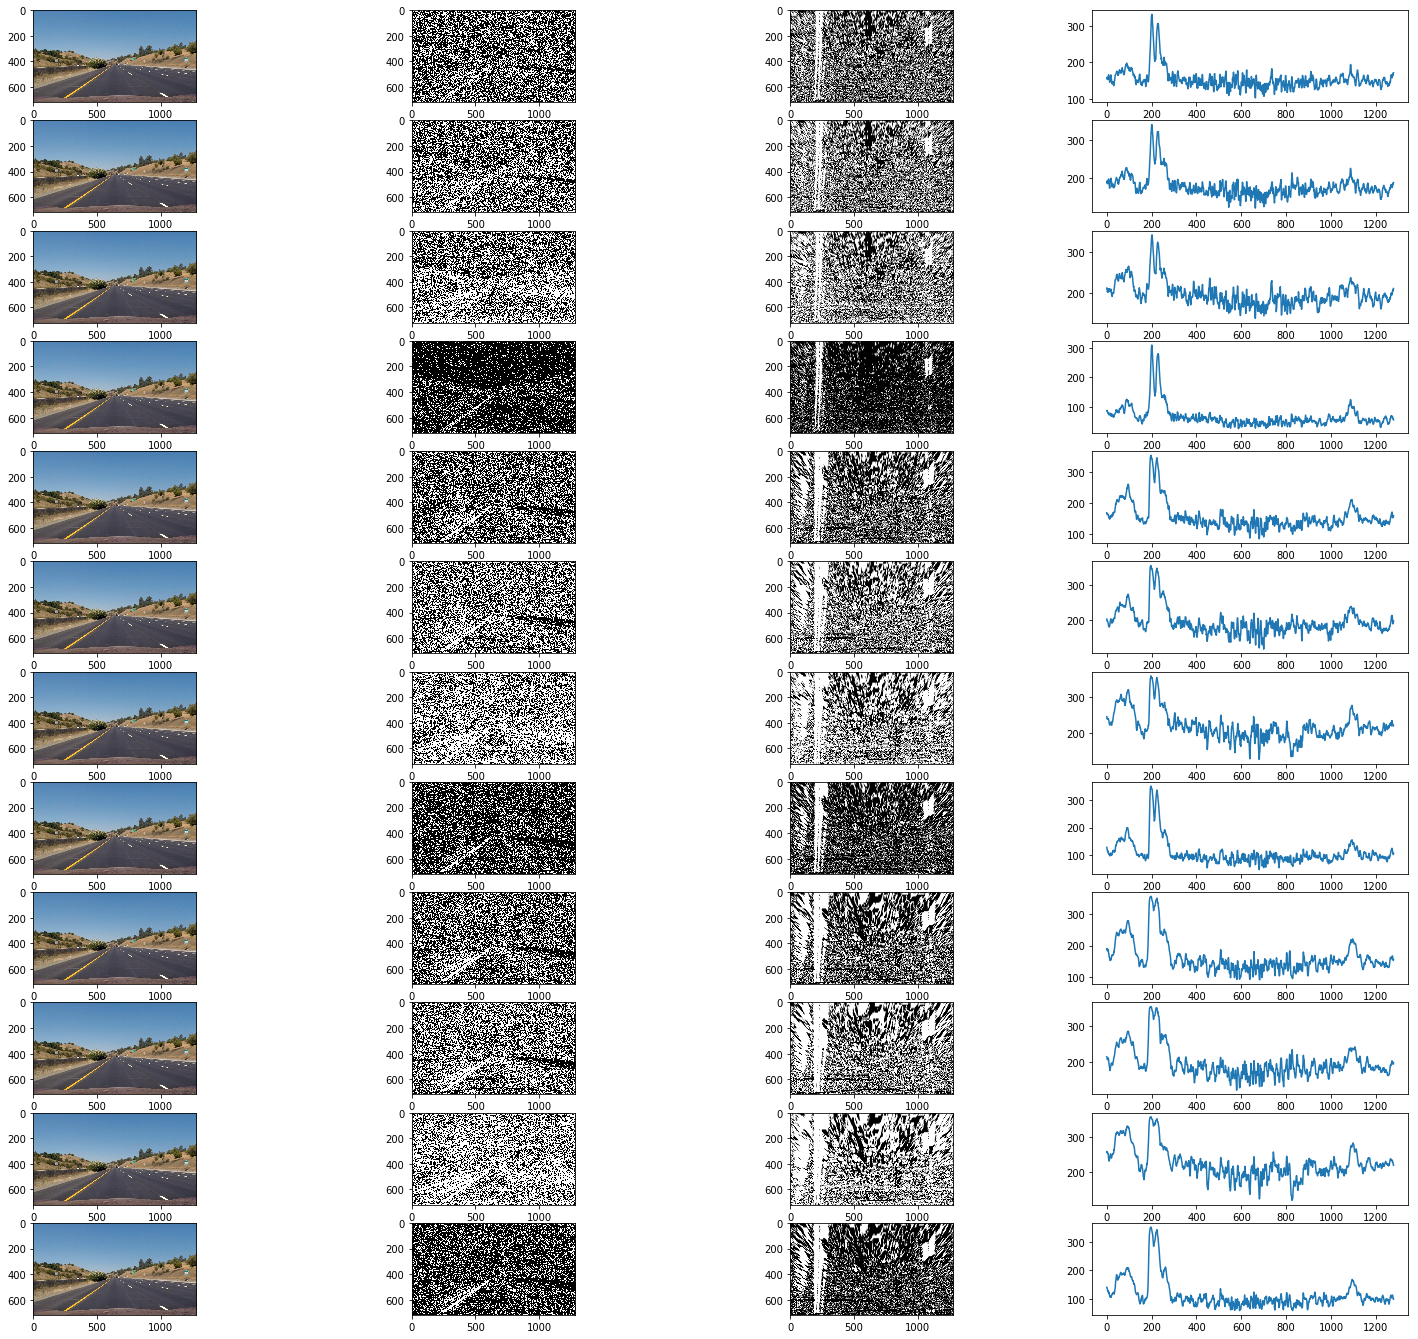

In [20]:
def sobel_dir_tune():
    """
        function to tune sobel_dir
    """
    testobj, testimg = calibrate_camera(calibration_files, NX, NY)
    img = cv2.imread(test_files[random.randrange(len(test_files))])
    undistorted = img_undistort(img, testobj, testimg)
    ksize = [3,9,15]
    sobel_thresh = [
        [0.7,1.3],
        [0.5,1.3],
        [0.7,1.5],
        [0.8,1.2]
    ]
    # gradx
    fig=plt.figure(figsize=(26, 24))
    i = 1
    r = 12
    c = 4
    for x in range(3):
        for y in range(4):
            gradx = sobel_thresh_dir(undistorted, ksize[x], thresh=(sobel_thresh[y][0], sobel_thresh[y][1]))
            transformed = apply_perspective_transform(gradx)
            histogram = return_histogram(transformed)
            i = print_image(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), fig, r, c, i)
            i = print_image(gradx, fig, r, c, i, cmap='gray')
            i = print_image(transformed, fig, r, c, i, cmap='gray')
            i = print_image(histogram, fig, r, c, i, isimg=False)

sobel_dir_tune()

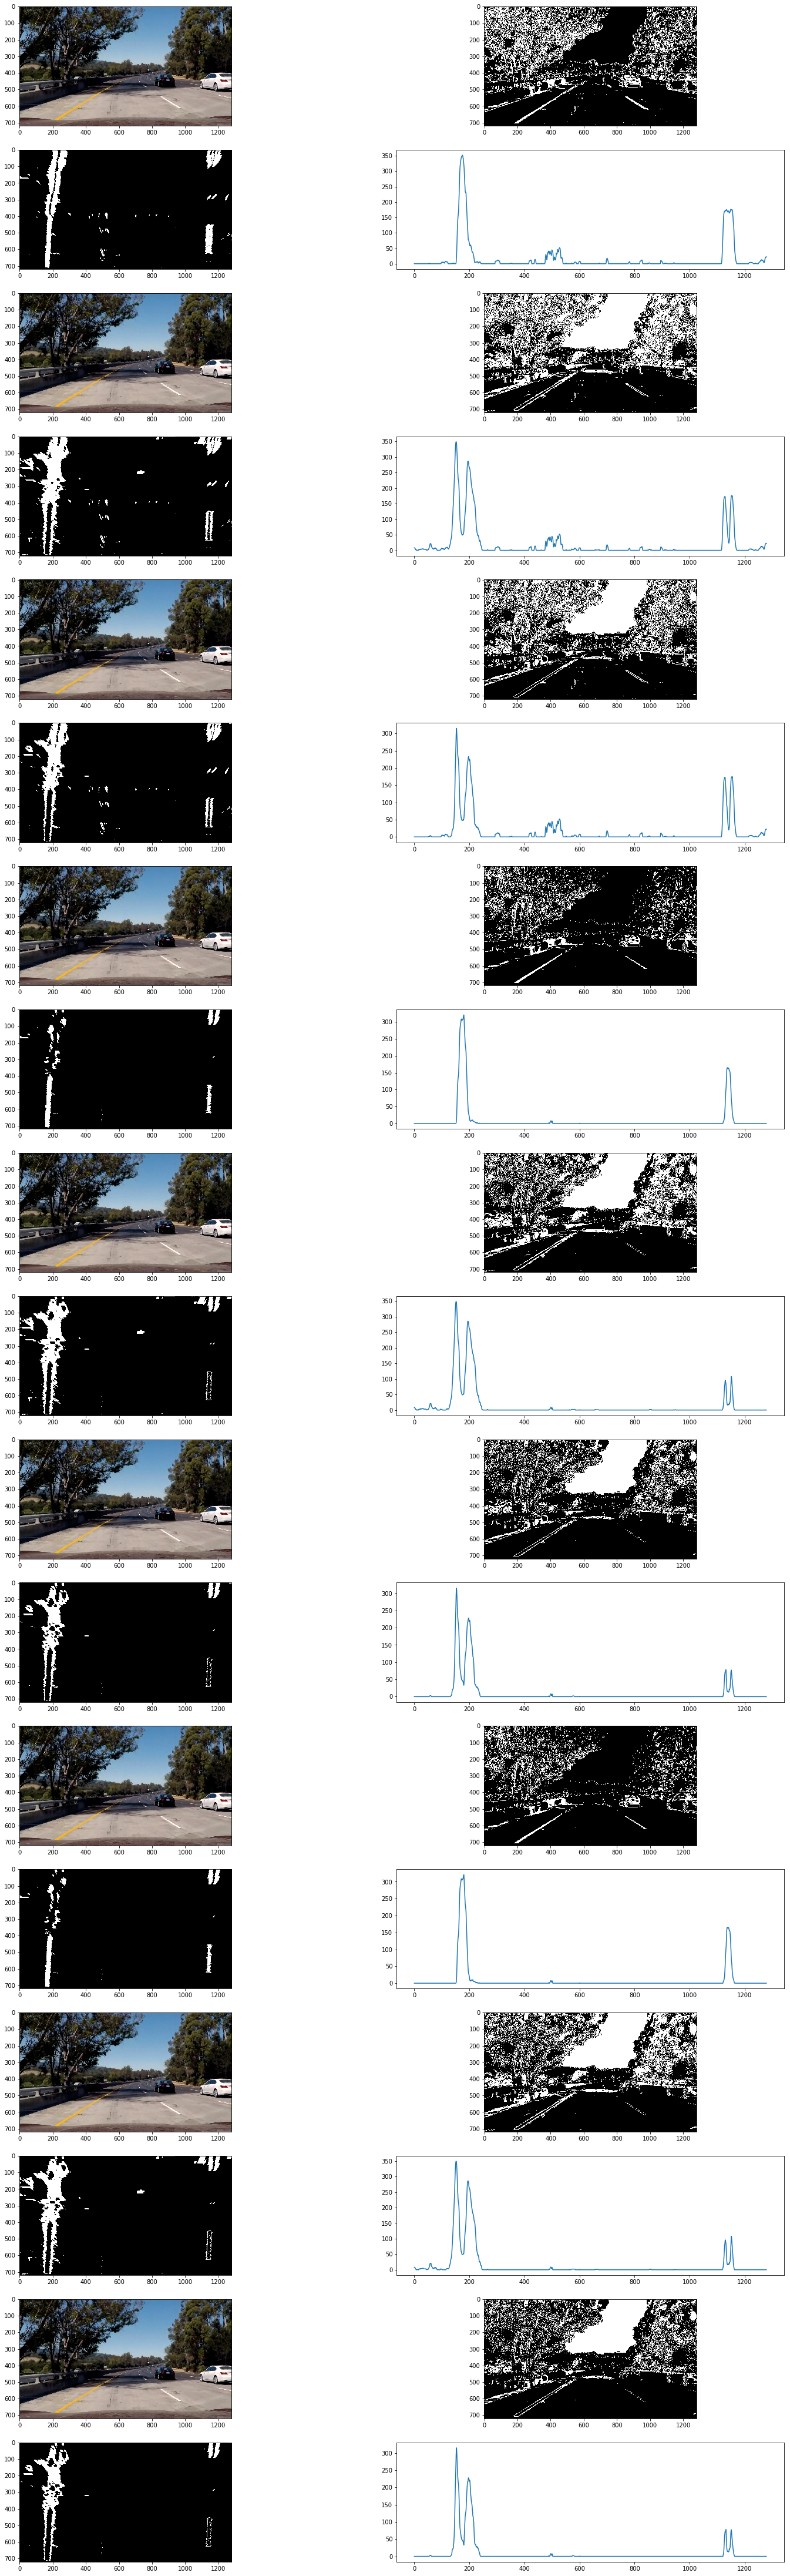

In [21]:
def combined_tune():
    """
        function to tune combined sobel_abs_x and hls
    """
    testobj, testimg = calibrate_camera(calibration_files, NX, NY)
    #img = cv2.imread(test_files[random.randrange(len(test_files))])
    img = cv2.imread(test_files[6])
    undistorted = img_undistort(img, testobj, testimg)
    sobel_thresh = [
        [20,100],
        [50,200],
        [50,150]
    ]
    color_thresh = [
        [150,255],
        [60,155],
        [75,150]
    ]
    # gradx
    fig=plt.figure(figsize=(26, 80))
    i = 1
    r = 18
    c = 2
    for x in range(3):
        for y in range(3):
            cbinary = get_gradhls_combined(undistorted, sobel_thresh=(sobel_thresh[x][0], sobel_thresh[x][1]),
                                          color_thresh=(color_thresh[y][0], color_thresh[y][1]))
            transformed = apply_perspective_transform(cbinary)
            histogram = return_histogram(transformed)
            i = print_image(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), fig, r, c, i)
            i = print_image(cbinary, fig, r, c, i, cmap='gray')
            i = print_image(transformed, fig, r, c, i, cmap='gray')
            i = print_image(histogram, fig, r, c, i, isimg=False)

combined_tune()

### Finding Lanes
In this section the lane finding techniques are defined as a sliding window is implemented to detect lines based on a histogram from a combined binary transformed image

In [22]:
def calculate_radius(ploty, x, y ):
    """
        function to define curve radius
        Args:
            ploty: the equal spaced from 0 to ymax
            x, y: current pixels for left or right in both axes
            
    """
    # evaluate radius at position of car bonnet
    y_eval = np.max(ploty)
    
    # conversions for pixels to metres
    ym_per_pix = 30/720 
    xm_per_pix = 3.7/700 
        
    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(y*ym_per_pix, x*xm_per_pix, 2)
        
    # Calculate the new radii of curvature
    return ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    
def calculate_offset(img, left_fitx, right_fitx):
    """
        function to calculate offset from center of lane
        Args:
            left_fitx, right_fitx: the fit pixels on the x axis
        Returns:
            the offset calculation
    """
    # pixel lane width according to right - left fit pixels
    lane_width_pixels = abs(left_fitx[-1] - right_fitx[-1])
    # lane center according to fit
    lane_center_x = (left_fitx[-1] + right_fitx[-1])//2
    # distance from center of lane in pixels
    pixel_offset_from_center = img.shape[1]//2 - lane_center_x
    
    # expected lane width
    lane_width_m = 3.7  
    # return the offset
    return lane_width_m * (pixel_offset_from_center/lane_width_pixels)

def seek_lanes(img, histogram, test_mode=False):
    """
        function to find lane lines from zero starting position
        Args:
            img: the binary thresholded and perspective transformed image
            histogram: the histogram of the lower half of the image
            test_mode: If true this will draw the sliding window lines onto the image
        Returns:
            left_fitx, right_fitx:
            ploty:
            leftcurve, rightcurve:
    """
    
    # create 3 channel version of binary image
    out_img = np.dstack((img, img, img))*255

    # find peaks
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = int(leftx_base)
    rightx_current = int(rightx_base)
    
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
    
        # Draw the windows on the visualization image
        if test_mode:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 4) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 4) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
    
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    def fit_lines():
        """
            function to fit left and right lane lines to img
            Returns:
                left_fitx, right_fitx: fit lines
        """
        ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        # calculate offset and return it...
        offset = calculate_offset(img, left_fitx, right_fitx)
        
        # calculate curve radii
        left_curverad = calculate_radius(ploty, leftx, lefty)
        right_curverad = calculate_radius(ploty, rightx, righty)
        
        return left_fitx, right_fitx, ploty, left_curverad, right_curverad, offset
    
    def print_lines():
        """
            function to draw lane lines onto image
        """
        fig=plt.figure(figsize=(5, 3))
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(leftx, py, color='red')
        plt.plot(rightx, py, color='red')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    leftx, rightx, py, lcurve, rcurve, offset = fit_lines()
    
    if test_mode: 
        print_lines()
    
    return left_fit, right_fit, leftx, rightx, py, lcurve, rcurve, offset

In [23]:
def find_lanes(img, left_fit, right_fit):
    """
        function to find lanes once a seek has been successful
        Args:
            img: the binary image to search
            left_fit, right_fit: existing fit arrays from previous frame
        Returns:
            leftx, rightx: new fit for frame
            py: plotting y space
            lcurve, rcurve: new calculated curvature
            offset: new offset
    """
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # calcluate the curvature and offset
    offset = calculate_offset(img, left_fitx, right_fitx)
        
    # calculate curve radii
    left_curverad = calculate_radius(ploty, leftx, lefty)
    right_curverad = calculate_radius(ploty, rightx, righty)
    
    return left_fit, right_fit, left_fitx, right_fitx, ploty, left_curverad, right_curverad, offset

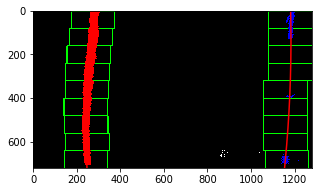

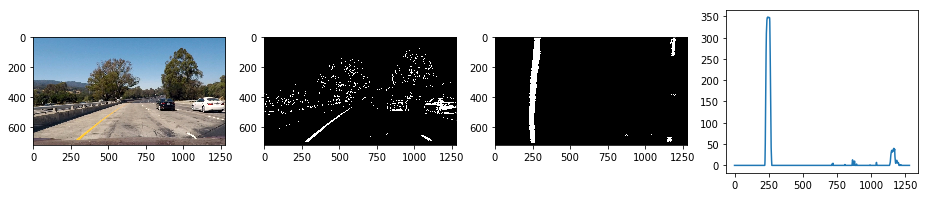

In [24]:
# let's look at the output
def show_line_fit():
    testobj, testimg = calibrate_camera(calibration_files, NX, NY)
    #img = cv2.imread(test_files[random.randrange(len(test_files))])
    img = cv2.imread(test_files[2])
    cbinary = get_gradhls_combined(img_undistort(img, testobj, testimg), sobel_thresh=(50, 150), 
                                   color_thresh=(150, 255))
    transformed = apply_perspective_transform(cbinary)
    histogram = return_histogram(transformed)
    lf, rf, lx, rx, ply, lc, rc, offset = seek_lanes(transformed, histogram, True)
    fig=plt.figure(figsize=(20, 3))
    i = 1
    r = 1
    c = 5
    i = print_image(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), fig, r, c, i)
    i = print_image(cbinary, fig, r, c, i, cmap='gray')
    i = print_image(transformed, fig, r, c, i, cmap='gray')
    i = print_image(histogram, fig, r, c, i, isimg=False)

show_line_fit()

In [25]:
def draw_output(img, warped, left_fitx, right_fitx, ploty, left_curve, right_curve, offset, bad_frames=0):
    """
        function to draw lines onto original image
        Args:
            img: original image
            warped: the warped image used for lane detection
            left_fitx, right_fitx: the fitted lines
            ploty: the linspace
            left_curve, right_curve, offest: annotations for the image
            bad_frames: tracking how many bad frames have been skipped
        Returns:
            a final image
    """
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = apply_perspective_transform(color_warp, reverse=True)
    font = cv2.FONT_HERSHEY_SIMPLEX
    radiusText = (50,50)
    offsetText = (50,75)
    frameText = (50,100)
    fontScale = 1
    fontColor = (255,255,255)
    lineType = 2

    cv2.putText(newwarp,'radius: {:.2f}m'.format(left_curve), 
        radiusText,
        font, 
        fontScale,
        fontColor,
        lineType)
    cv2.putText(
        newwarp,
        'center-lane offset: {:.2f}m'.format(offset),
        offsetText,  # origin point
        font,
        fontScale,
        fontColor,
        lineType
    )
    if bad_frames > -1:
        cv2.putText(
            newwarp,
            'bad frames: {0}'.format(bad_frames),
            frameText,  # origin point
            font,
            fontScale,
            fontColor,
            lineType
        )
    
    # Combine the result with the original image
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

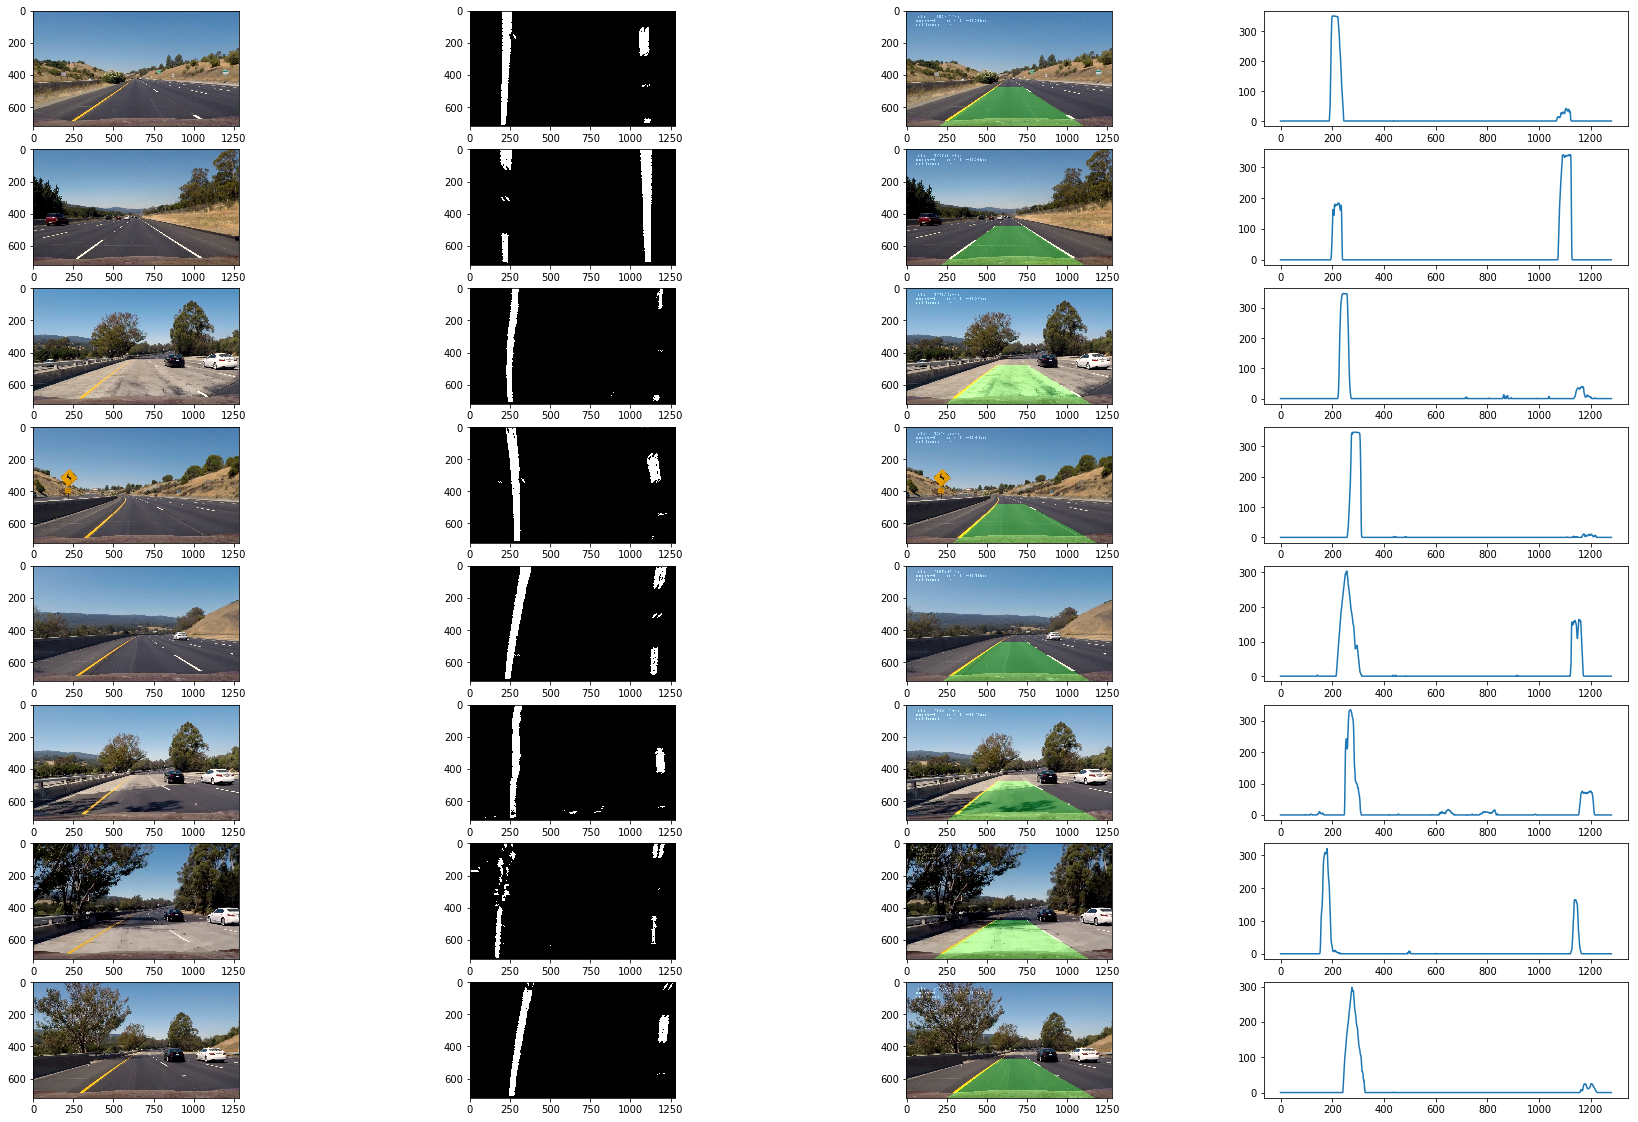

In [26]:
def draw_all_test():
    """
        function to show lane lines detected on all the test images
    """
    fig=plt.figure(figsize=(30, 20))
    r = len(test_files)
    c = 4
    i = 1
    # iterate test_files and create a list of images
    testobj, testimg = calibrate_camera(calibration_files, NX, NY)
    for x in range(len(test_files)):
        img = cv2.imread(test_files[x])
        cbinary = get_gradhls_combined(img_undistort(img, testobj, testimg), sobel_thresh=(50, 150), 
                                       color_thresh=(150, 255))
        transformed = apply_perspective_transform(cbinary)
        histogram = return_histogram(transformed)
        left_fit, right_fit, left_fitx, right_fitx, ploty, left_curve, right_curve, offset = seek_lanes(transformed, histogram)
        line_img = draw_output(img, transformed, left_fitx, right_fitx, ploty, left_curve, right_curve, offset)
        i = print_image(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), fig, r, c, i)
        i = print_image(transformed, fig, r, c, i, cmap='gray')
        i = print_image(cv2.cvtColor(line_img, cv2.COLOR_BGR2RGB), fig, r, c, i)
        i = print_image(histogram, fig, r, c, i, isimg=False)

draw_all_test()

#### Video Processing Section
This is where input videos are processed and each frame is passed to a lane detector class to detect lines. Lines are averaged over the last n frames. Lane seeking is only done from scratch on the first frame or where the lane detector has lost sight of the lanes.

In [29]:
class lane_detector():
    """
        class definition for an advanced lane detector
        relies on pre-defined functions above in this notebook
    """
    
    def __init__(self):
        """
            initialisation of class to be used for averaging lane lines etc
        """
        # threshold defaults
        self.ksize = 9
        self.sobel_thresh = (50, 150) 
        self.direction_thresh =  (0.7, 1.3)
        self.color_thresh = (150, 255)
        self.output_mode = 'live'
        
        # calibrate the camera
        self.IMG_DIR = 'camera_cal/'
        self.calibration_files = glob.glob(self.IMG_DIR+"*.jpg")
        self.NX = 9
        self.NY = 6
        self.testobj, self.testimg = calibrate_camera(self.calibration_files, self.NX, self.NY)
        
        # track lanes need to be sought and track last n things...always start by seeking
        self.seek_lanes = True
        self.average_over_frames = 5
        self.bad_frames = 0
        self.left_fit_list = collections.deque(maxlen=self.average_over_frames)
        self.right_fit_list = collections.deque(maxlen=self.average_over_frames)
        self.left_curve_list = collections.deque(maxlen=self.average_over_frames)
        self.right_curve_list = collections.deque(maxlen=self.average_over_frames)
        self.lane_offset_list = collections.deque(maxlen=self.average_over_frames)
        self.best_left_fit = []
        self.best_right_fit = []
        self.best_left_curve = 0
        self.best_right_curve = 0
        self.best_lane_offset = 0
        
    def append_lists(self,left_fit, right_fit, left_curve, right_curve, offset):
        self.left_fit_list.append(left_fit)
        self.best_left_fit = np.mean(self.left_fit_list, axis=0)
        
        self.right_fit_list.append(right_fit)
        self.best_right_fit = np.mean(self.right_fit_list, axis=0)
        
        self.left_curve_list.append(left_curve)
        self.best_left_curve = np.mean(self.left_curve_list)
        
        self.right_curve_list.append(right_curve)
        self.best_right_curve = np.mean(self.right_curve_list)
        
        self.lane_offset_list.append(offset)
        self.best_lane_offset = np.mean(self.lane_offset_list)
        
    def check_lane_sanity(self, left_fit, right_fit, 
                               left_curve, right_curve, offset):
        # check the goodness of fit of the new line
        # is the left_fit close to the current left_fit?
        left_test = np.absolute(np.subtract(left_fit[2], self.best_left_fit[2]))
        right_test = np.absolute(np.subtract(right_fit[2], self.best_right_fit[2]))
        left_curve_test = np.absolute(np.subtract(left_curve, self.best_left_curve))
        right_curve_test = np.absolute(np.subtract(right_curve, self.best_right_curve))
        offset_test = np.absolute(np.subtract(offset, self.best_lane_offset))
        if (left_test > 75 or right_test > 75):
            # we have a bad frame
            self.bad_frames += 1
            if self.bad_frames == 7:
                # make us search afresh next time and reset bad lanes
                self.seek_lanes = True
                self.bad_frames = 0
            return 0
        else:
            self.bad_frames = 0
            return -1
        
    def get_plot_lines(self, img):
        # Generate x and y values for plotting
        ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
        left_fitx = self.best_left_fit[0]*ploty**2 + self.best_left_fit[1]*ploty + self.best_left_fit[2]
        right_fitx = self.best_right_fit[0]*ploty**2 + self.best_right_fit[1]*ploty + self.best_right_fit[2]
        return (ploty, left_fitx, right_fitx)
    
    def process_image(self, img):
        """
            function to pass to video processing
            Args:
                Video clip to process: should be color image
            Returns:
                image with detected lane lines
        """
        # get the binary threshold across sobel_absx and hsv on an undistorted image
        undistort = img_undistort(img, self.testobj, self.testimg)
        cbinary = get_gradhls_combined(undistort, self.sobel_thresh, self.color_thresh)
        transformed = apply_perspective_transform(cbinary)
        histogram = return_histogram(transformed)
        
        # do we need to seek? will use last 1 to begin with
        if self.seek_lanes:
            left_fit, right_fit, left_fitx, right_fitx, ploty, left_curve, right_curve, offset = seek_lanes(transformed, 
                                                                                                            histogram)
            self.seek_lanes = False
            sane_line = -1
        else:
            left_fit, right_fit, left_fitx, right_fitx, ploty, left_curve, right_curve, offset = find_lanes(transformed, 
                                                                                       self.left_fit_list[-1],
                                                                                       self.right_fit_list[-1])
            sane_line = self.check_lane_sanity(left_fit, right_fit, 
                                          left_curve, right_curve, offset)
            
        if sane_line == -1:
            # if -1 ok to append line
            self.append_lists(left_fit, right_fit, 
                              left_curve, right_curve, offset)
        
        lines_to_plot = self.get_plot_lines(transformed)
        
        new_img = draw_output(undistort, transformed, 
                              lines_to_plot[1], 
                              lines_to_plot[2], 
                              lines_to_plot[0], 
                              self.best_left_curve, 
                              self.best_right_curve, 
                              self.best_lane_offset,
                              self.bad_frames)
        
        if self.output_mode == 'test':
            fig=plt.figure(figsize=(15, 5))
            r = 1
            c = 4
            i = 1
            atitle = "l2: {:.2f}, r2 {:.2f}".format(left_fit[2], right_fit[2])
            atitle1 = "l2: {:.2f}, r2 {:.2f}".format(left_fit[1], right_fit[0])
            atitle2 = "l2: {:.2f}, r2 {:.2f}".format(left_fit[1], right_fit[0])
            aradius = "lc {:.2f}, rc{:.2f}, bf".format(left_curve, right_curve, self.bad_frames)
            i = print_image(new_img, fig, r, c, i, title=atitle)
            i = print_image(transformed, fig, r, c, i, cmap='gray', title=aradius)
            i = print_image(cbinary, fig, r, c, i, cmap='gray', title=atitle1)
            i = print_image(histogram, fig, r, c, i, isimg=False, title=atitle2)
        
        return new_img

In [ ]:
# create a lane detector
TEST_MODE = False
detector = lane_detector()
detector.output_mode = 'live'
#detector.output_type = None
output = 'project_video_output.mp4'
##output = 'output_videos/challenge1.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("project_video.mp4").subclip(39,44)
##clip1 = VideoFileClip("project_video.mp4")
##clip1 = VideoFileClip("input_videos/challenge_video.mp4")
###clip1 = VideoFileClip("input_videos/harder_challenge_video.mp4")
white_clip = clip1.fl_image(detector.process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)